<font color='#00AED3'>

# EduCreate | RAG Model Evaluation </font>



# Setup and Import Modules

In [1]:
%%capture
# Install required modules and packages
%pip install --upgrade --quiet langchain-qdrant langchain-openai langchain-anthropic langchain langchain-community wikipedia openai langchain_huggingface tiktoken anthropic

In [2]:
# Import modules and packages
import torch
import os
from pprint import pprint
import locale
import json
import re
import io
import requests
import numpy as np
import tiktoken
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter

from langchain import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_anthropic import ChatAnthropic
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_qdrant import Qdrant
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.utils.math import cosine_similarity

from google.colab import userdata

from openai import OpenAI
from anthropic import Anthropic

locale.getpreferredencoding = lambda: "UTF-8"

client_openai = OpenAI(api_key = userdata.get("OPENAI_API_KEY_W210"))

client_anthropic = Anthropic(api_key=userdata.get("ANTHROPIC_API_KEY"))

openai_model = "gpt-4o-mini"
anthropic_model = "claude-3-5-sonnet-20240620"

# Training and Test Datasets

In [ ]:
training_dataset = {
    0: {'question': "How did the United States respond to the discovery of Soviet missiles in Cuba?",
        'answer': "When the United States discovered the presence of Soviet missiles in Cuba in October 1962, President John F. Kennedy and his administration responded swiftly and decisively. Kennedy\'s response to the Cuban Missile Crisis was multi-faceted and aimed at resolving the situation without escalating it into a full-scale nuclear war. \n\nFirstly, Kennedy ordered a naval blockade of Cuba to prevent further military supplies from reaching the island. This blockade was established on October 24, 1962, and was termed a 'quarantine' to avoid direct conflict with the Soviet Union.\n\nSecondly, Kennedy delivered a televised address to the nation on October 22, 1962, informing the American public about the presence of the Soviet missiles in Cuba and declaring that the U.S. would not tolerate such provocative actions. He also demanded the immediate removal of the missiles, warning of severe consequences if his demands were not met.\n\nThirdly, Kennedy engaged in backchannel communications with Soviet Premier Nikita Khrushchev to seek a diplomatic solution to the crisis. Through these secret communications, Kennedy proposed a deal in which the U.S. pledged not to invade Cuba if the Soviet Union agreed to remove the missiles. \n\nLastly, the U.S. military was placed on high alert, with Strategic Air Command (SAC) bombers and forces ready to respond to any potential aggression from the Soviet Union. This show of military preparedness was intended to deter any further escalation of the crisis.\n\nIn the end, through a combination of diplomatic negotiations, a firm stance, and a willingness to compromise, the United States successfully resolved the Cuban Missile Crisis without resorting to military conflict. The crisis brought the world to the brink of nuclear war but ultimately led to a de-escalation of tensions between the United States and the Soviet Union and highlighted the importance of communication and diplomacy in resolving international conflicts."},
    2: {'question': "What was the significance of the quarantine imposed by the United States during the crisis?",
        'answer': "The quarantine imposed by the United States during the Cuban Missile Crisis was a strategic move of placing a naval blockade, referred to as a 'quarantine' to avoid the term blockade which legally implied an act of war, around Cuba to prevent the Soviet Union from delivering more missiles and military equipment. This action was significant for several reasons: \n\n1. It demonstrated a firm U.S. response to the Soviet threat without resorting to immediate military action, showing a willingness to engage in diplomacy first.\n\n2. The quarantine bought time for diplomatic negotiations to take place between the U.S. and the Soviet Union, enabling the two superpowers to engage in direct communication and seek a peaceful resolution to the crisis.\n\n3. By imposing a naval quarantine, the U.S. was able to visibly show its determination to prevent further Soviet escalation in the Western Hemisphere, particularly in such close proximity to U.S. shores.\n\n4. The quarantine helped garner international support for the U.S. position, as it was seen as a measured and reasonable response to Soviet aggression, unlike a full-scale military invasion of Cuba.\n\n5. Ultimately, the quarantine paved the way for a peaceful resolution to the crisis, as it created a pause in hostilities that allowed negotiations to occur and averted a potential nuclear conflict between the United States and the Soviet Union.\n\nIn essence, the quarantine imposed by the United States during the Cuban Missile Crisis was crucial in preventing further escalation of the conflict, providing a window for diplomatic efforts, and ultimately leading to a peaceful resolution that averted a catastrophic nuclear war."},
    5: {'question': "How did the Cuban Missile Crisis come to an end?",
        'answer': "The Cuban Missile Crisis came to an end through a series of diplomatic negotiations and significant concessions made by both the United States and the Soviet Union. \n\nFollowing intense discussions and negotiations between President John F. Kennedy and Premier Nikita Khrushchev, a resolution was reached. On October 28, 1962, Khrushchev agreed to remove the Soviet missiles from Cuba in exchange for a public commitment from the U.S. not to invade Cuba and a private agreement to remove American missiles from Turkey. This agreement was communicated through back-channel communications between the two superpowers.\n\nOnce the agreement was reached, Khrushchev announced the Soviet Union's decision to dismantle the missile sites in Cuba. This effectively marked the end of the Cuban Missile Crisis and diffused the tension that had threatened to escalate into a full-blown nuclear conflict between the U.S. and the Soviet Union.\n\nThe resolution of the Cuban Missile Crisis is widely regarded as a triumph of diplomacy and a crucial moment in the history of the Cold War. It highlighted the dangers of nuclear brinkmanship and the importance of communication and negotiation in averting catastrophic conflict between nuclear-armed powers."},
    6: {'question': "What lessons were learned from the Cuban Missile Crisis in terms of nuclear diplomacy?",
        'answer': "The Cuban Missile Crisis provided several valuable lessons in the realm of nuclear diplomacy:\n\n1. **Importance of Communication and Diplomacy:** The crisis highlighted the critical importance of maintaining open lines of communication between the involved parties to prevent misunderstandings and miscalculations that could lead to nuclear conflict. Direct communication between President Kennedy and Premier Khrushchev ultimately played a key role in resolving the crisis.\n\n2. **Value of Negotiation and Compromise:** The Cuban Missile Crisis demonstrated that diplomatic negotiation and compromise can be effective tools in de-escalating nuclear tensions. Both the U.S. and the Soviet Union were able to reach a peaceful resolution through back-channel communications and concessions on both sides.\n\n3. **Recognition of the Dangers of Escalation:** The crisis underscored the extreme risks associated with nuclear brinkmanship and the potential for rapid escalation of conflicts between nuclear-armed powers. It served as a sobering reminder of the catastrophic consequences of nuclear war.\n\n4. **Importance of Strategic Restraint:** The Cuban Missile Crisis highlighted the need for strategic restraint and careful consideration of the consequences of military actions in a nuclear context. Both sides demonstrated a degree of caution to avoid actions that could spiral out of control.\n\n5. **Emphasis on Confidence-Building Measures:** Following the crisis, both the U.S. and the Soviet Union engaged in efforts to establish confidence-building measures to reduce the likelihood of future nuclear crises. This included the establishment of a direct hotline between the White House and the Kremlin to ensure rapid communication in times of crisis.\n\n6. **Role of Third-Party Mediation:** The Cuban Missile Crisis also illustrated the potential value of third-party mediation in resolving conflicts between nuclear-armed states. In this case, the intervention of the United Nations played a role in facilitating negotiations and defusing tensions.\n\nOverall, the Cuban Missile Crisis served as a pivotal moment in the history of nuclear diplomacy, providing valuable insights into the dynamics of nuclear conflict and the necessity of effective crisis management strategies to prevent catastrophic outcomes."},
    7: {'question': "How did the Cuban Missile Crisis influence future arms control agreements between the United States and the Soviet Union?",
        'answer': "The Cuban Missile Crisis played a significant role in shaping future arms control agreements between the United States and the Soviet Union. The intense confrontation and the risk of nuclear war highlighted the urgent need for mechanisms to prevent similar crises in the future. As a result of the crisis, both superpowers realized the importance of direct communication and dialogue in managing conflicts and reducing tensions. \n\nOne of the immediate outcomes of the crisis was the establishment of a direct communication line between Washington and Moscow, known as the 'hotline'. This direct line of communication allowed the leaders of both countries to communicate quickly and efficiently to avoid misunderstandings that could escalate into a crisis.\n\nFurthermore, the Cuban Missile Crisis heightened awareness of the dangers of nuclear proliferation and the need for arms control agreements to limit the spread of nuclear weapons. This led to the signing of the Limited Nuclear Test Ban Treaty in 1963, which prohibited nuclear testing in the atmosphere, outer space, and underwater. \n\nThe crisis also set the stage for further arms control agreements, such as the Strategic Arms Limitation Talks (SALT) in the 1970s. The SALT agreements aimed to limit the number of intercontinental ballistic missiles (ICBMs) and submarine-launched ballistic missiles (SLBMs) possessed by both countries. These agreements played a crucial role in reducing the arms race between the United States and the Soviet Union and promoting stability and predictability in their relationship.\n\nOverall, the Cuban Missile Crisis served as a wake-up call for both superpowers, emphasizing the need for arms control agreements, diplomatic solutions to conflicts, and mechanisms to prevent nuclear war. The lessons learned from the crisis influenced future negotiations and laid the groundwork for further arms control agreements between the United States and the Soviet Union, ultimately contributing to the easing of Cold War tensions."},
    8: {'question': "What role did William the Conqueror play in the Battle of Hastings and the Norman Conquest of England?",
        'answer': "William the Conqueror, also known as William I, played a crucial role in the Battle of Hastings and the Norman Conquest of England. After the death of King Edward the Confessor of England, both William and Harold Godwinson claimed the English throne. William believed that he had been promised the throne by King Edward and that Harold had wrongfully assumed the crown. William was determined to secure his claim and invade England.\n\nAt the Battle of Hastings on October 14, 1066, William's Norman army faced Harold's Anglo-Saxon forces. William demonstrated strategic skill and leadership during the battle, utilizing innovative tactics such as feigned retreats to break the Anglo-Saxon shield wall. Despite fierce resistance from Harold's forces, the Normans ultimately emerged victorious, and Harold was killed in the battle.\n\nFollowing his victory at Hastings, William continued his military campaigns to consolidate his control over England. He faced several rebellions and uprisings from Anglo-Saxon nobles, but he systematically subdued opposition, built castles to exert control over the country, and implemented a system of governance that integrated Norman feudal practices with existing English institutions. William's rule marked the beginning of Norman rule in England and the transformation of English society, culture, and language.\n\nWilliam's legacy as the Conqueror is profound. His victory at Hastings and the subsequent Norman Conquest reshaped the political, social, and cultural landscape of England. The imposition of Norman feudalism, the Domesday Book survey, the construction of castles, and the establishment of a new aristocracy were among the lasting impacts of William's reign. The Norman Conquest also had long-term consequences for the English language, introducing French vocabulary that would eventually merge with Old English to form Middle English.\n\nIn conclusion, William the Conqueror's leadership and military prowess were instrumental in the Battle of Hastings and the Norman Conquest of England. His reign as King of England marked a significant turning point in English history, ushering in a new era of Norman rule and shaping the course of the nation for centuries to come."},
    10: {'question': "Why was the Battle of Hastings a significant turning point in English history and the Norman Conquest?",
         'answer': "The Battle of Hastings in 1066 was a significant turning point in English history as it marked the beginning of the Norman Conquest and the end of Anglo-Saxon rule in England. The Norman victory at Hastings led to William the Conqueror establishing Norman rule over England, bringing about significant political, social, and cultural changes.\n\nFirstly, the Battle of Hastings resulted in the death of King Harold II, the last Anglo-Saxon king of England. Harold's death left a power vacuum that William the Conqueror exploited to claim the English crown, solidifying Norman control over the country. This marked the end of the Anglo-Saxon era and the beginning of Norman rule.\n\nAdditionally, William the Conqueror's victory at Hastings allowed him to implement feudalism in England. Through the redistribution of land and the establishment of a feudal system, William was able to consolidate his power and reward his Norman followers with lands and titles, leading to the emergence of a new Norman aristocracy in England.\n\nMoreover, the Norman Conquest brought about significant cultural changes in England. The Normans introduced Norman French as the language of the court and administration, leading to the blending of Anglo-Saxon and Norman cultures and the enrichment of the English language with Norman vocabulary.\n\nThe Battle of Hastings also had long-lasting implications for English society. The Norman Conquest brought about the construction of impressive castles and cathedrals, the introduction of new architectural styles, and the centralization of power under the monarchy.\n\nIn conclusion, the Battle of Hastings was a pivotal moment in English history as it marked the beginning of the Norman Conquest and the establishment of Norman rule in England. The defeat of the Anglo-Saxon forces led to significant political, social, and cultural changes that shaped the course of English history for centuries to come."},
    12: {'question': "How did the Battle of Senlac Hill (Battle of Hastings) unfold, and what were the key factors that led to the Norman victory?",
         'answer': "The Battle of Hastings, which took place on Senlac Hill on October 14, 1066, unfolded in several key stages. Early in the morning, the Norman army led by Duke William of Normandy advanced toward the English position, where King Harold II had positioned his forces on the top of Senlac Hill. Harold's army formed a shield wall, a traditional Anglo-Saxon defense tactic. The Norman army, consisting of infantry, archers, and cavalry, faced challenges attacking the English shield wall.\n\nOne of the key factors that led to the Norman victory was the feigned Norman retreat. The Normans pretended to retreat in an effort to lure some of the English forces out of their defensive position. This tactic was successful, as a portion of the English army broke ranks to pursue the retreating Normans. This break in the shield wall allowed the Normans to launch a counterattack and exploit the gap in the English defenses.\n\nAdditionally, the Norman cavalry played a crucial role in the battle. While Harold's forces were primarily infantry-based, Duke William had heavily armored horsemen who were able to maneuver more effectively on the battlefield. The Norman cavalry charged at the English lines, causing chaos and disarray among the English troops.\n\nFurthermore, the Norman use of archers also contributed to their victory. The Norman archers rained arrows down on the English forces from a distance, weakening the shield wall and causing casualties among the English ranks.\n\nUltimately, the combination of strategic tactics such as the feigned retreat, the effective use of cavalry and archers, and the discipline of the Norman army played significant roles in their victory at the Battle of Hastings. The death of King Harold II during the battle also had a demoralizing effect on the English forces, further aiding the Normans in securing their triumph and establishing Norman rule in medieval England."},
    13: {'question': "What were the motivations of Harold Godwinson and William the Conqueror in their respective claims to the English throne in 1066?",
         'answer': "Harold Godwinson's claim to the English throne stemmed from his appointment by King Edward the Confessor on his deathbed. Harold was a powerful noble in England and had significant support from the English nobility. His motivation was to maintain stability and continuity within England. He believed he was the rightful heir and was chosen by Edward to succeed him. Harold's claim was also supported by the Witan, the council of nobles that had the authority to elect the king.\n\nOn the other hand, William the Conqueror's claim to the English throne was based on an alleged promise by Harold himself and a distant blood connection to Edward the Confessor. William's motivation was fueled by his ambition to expand his territory and influence. He believed that Harold had sworn an oath to support his claim to the throne when he visited William in Normandy. When Harold was crowned king, William saw this as a betrayal of that oath and used it as a justification for his invasion of England.\n\nBoth Harold and William believed they had legitimate claims to the English throne, but their motivations were different. Harold sought to uphold the traditional English succession process and maintain stability within the kingdom, while William sought to expand his power and territories through conquest. The clash between these conflicting claims and motivations ultimately led to the Battle of Hastings in 1066, where William emerged victorious and established Norman rule in medieval England."},
    14: {'question': "What were the repercussions of the Battles of Gate Fulford and Stamford Bridge on the Norman Conquest of England?",
         'answer': "The Battles of Gate Fulford and Stamford Bridge had significant repercussions on the Norman Conquest of England in 1066. These battles occurred just before the Battle of Hastings and had a direct impact on the events that followed.\n\nThe first repercussion was the weakening of Harold's forces. Prior to the Battle of Hastings, Harold's army had to face two major battles against Harald Hardrada of Norway at Stamford Bridge and Tostig Godwinson. The battles resulted in casualties, depletion of resources, and exhaustion among the Anglo-Saxon troops. This weakened Harold's position and military readiness when William the Conqueror invaded shortly after.\n\nAnother important repercussion was the division of the English forces. The conflicts at Gate Fulford and Stamford Bridge created divisions within the English nobility and military leadership. There were rivalries among various factions, such as Edwin and Morcar against Harold, which weakened the overall unity and coordination of the English defense.\n\nFurthermore, these battles also changed the dynamics of the Norman Conquest. The defeat of Harald Hardrada at Stamford Bridge by Harold Godwinson's forces led to the elimination of one threat to the English throne. However, this victory came at a cost, as it left Harold's army in a weakened state just before the Norman invasion.\n\nIn conclusion, the Battles of Gate Fulford and Stamford Bridge had repercussions that directly impacted the Norman Conquest of England in 1066. These battles weakened Harold's forces, created divisions within the English leadership, and changed the strategic landscape leading up to the Battle of Hastings. Though the English were successful in repelling the initial invasions, their strength and unity were compromised, ultimately contributing to the Norman victory and the establishment of Norman rule in medieval England."},
    15: {'question': "How did the Battles of 1066 ultimately solidify Norman rule in medieval England and shape the country's future?",
         'answer': "The Battles of 1066 were pivotal in solidifying Norman rule in medieval England and shaping the country's future in several ways:\n\n1. **Battle of Stamford Bridge (September 25, 1066)**: King Harold II of England decisively defeated the Norwegian invasion force led by King Harald Hardrada and Earl Tostig. Although this battle ended in an English victory, it weakened Harold's forces and left the Anglo-Saxon army depleted and exhausted.\n\n2. **Battle of Hastings (October 14, 1066)**: Following the victory at Stamford Bridge, Harold's army had to immediately march south to confront William of Normandy at the Battle of Hastings. The Normans and the Anglo-Saxons clashed in a brutal and bloody battle that ultimately resulted in Harold's death and the defeat of the English forces. William emerged victorious, solidifying Norman rule in England.\n\n3. **Norman Conquest**: William the Conqueror, now William I of England, was crowned king on Christmas Day 1066. The Norman Conquest marked the beginning of Norman rule in England, leading to significant political, social, and cultural changes in the country. The Normans introduced feudalism and centralized government, reshaping the English political landscape.\n\n4. **Norman Influence**: The Normans brought their own language (Norman French) and customs to England, leading to a blending of Anglo-Saxon and Norman cultures. This fusion of cultures laid the foundation for the development of Middle English and influenced English society for centuries to come.\n\n5. **Domesday Book**: In 1086, William the Conqueror commissioned the Domesday Book, a comprehensive survey of landholdings and property ownership in England. The Domesday Book was a landmark in English administrative history and helped centralize royal authority under Norman rule.\n\n6. **Feudal System**: The Norman Conquest solidified the feudal system in England, with William redistributing land to his Norman supporters in exchange for military service and loyalty. The feudal system brought about significant changes in land ownership, agriculture, and governance in medieval England.\n\nOverall, the Battles of 1066 and the Norman Conquest had a lasting impact on England, shaping its future political, social, and cultural development. The Normans transformed England into a Norman-dominated kingdom, laying the foundation for the medieval English monarchy and leaving a lasting legacy that continues to influence the country to this day."},
    16: {'question': "How did the formation of NATO and the Warsaw Pact affect the balance of power during the Cold War?",
         'answer': "The formation of NATO (North Atlantic Treaty Organization) and the Warsaw Pact significantly affected the balance of power during the Cold War. NATO was established in 1949 as a defensive alliance of Western European and North American countries to counter the perceived threat posed by the Soviet Union and its allies. It served as a deterrent against Soviet aggression and provided a collective security mechanism for its members. The United States, in particular, played a key role in NATO, enhancing its military presence in Europe and solidifying its commitment to the security of its allies. The Warsaw Pact, formed in 1955 in response to West Germany's integration into NATO and the remilitarization of Western Europe, was a military alliance composed of Eastern European countries under the leadership of the Soviet Union. It served as a means for the Soviet Union to maintain control over its satellite states and expand its influence in the region. The Warsaw Pact also provided a counterbalance to NATO and reinforced the division of Europe into two opposing blocs. The existence of NATO and the Warsaw Pact created a bipolar world order during the Cold War, with the United States and the Soviet Union as the two superpowers leading their respective alliances. This resulted in a tense geopolitical environment characterized by military build-ups, ideological competition, and proxy wars in various parts of the world. The balance of power between the two alliances influenced global politics, security strategies, and diplomatic relations for decades, shaping the course of the Cold War and its eventual conclusion in 1991."},
    17: {'question': "What role did the Korean War play in escalating tensions between the USA and the USSR during the Cold War?",
         'answer': "The Korean War played a significant role in escalating tensions between the USA and the USSR during the Cold War. The conflict in Korea was seen as a proxy war between the two superpowers. The USA supported South Korea, while the USSR supported North Korea. The Korean War demonstrated the policy of containment in action for the USA. This policy aimed to prevent the spread of communism, and the US saw North Korea's invasion of South Korea as a clear example of communist aggression. The USSR's support for North Korea and China's involvement in the war raised concerns for the USA about the spread of communism in Asia. This fueled fears of communist expansion and solidified the US commitment to stopping its spread. The Korean War also led to increased military spending and the arms race between the USA and the USSR, further heightening tensions between the two superpowers. Overall, the Korean War was a key event that intensified the rivalry and competition between the USA and the USSR during the Cold War period."},
    18: {'question': "How did the Cuban Missile Crisis bring the world to the brink of nuclear war?",
         'answer': "The Cuban Missile Crisis of October 1962 brought the world to the brink of nuclear war as a result of escalating tensions between the United States and the Soviet Union over the placement of Soviet missiles in Cuba. The crisis began when the United States discovered that the Soviet Union was secretly installing nuclear missiles in Cuba, which could potentially reach major cities in the United States.\n\nIn response, President John F. Kennedy implemented a naval blockade of Cuba to prevent further missile shipments and demanded the removal of the missiles already in place. The situation became increasingly tense as both sides engaged in brinkmanship, with the world anxiously watching to see if the crisis would escalate into a full-scale nuclear conflict.\n\nAt one point, a U.S. U-2 spy plane was shot down over Cuba, further raising the stakes. As the two superpowers stood on the brink of war, backchannel diplomacy and tense negotiations took place between Kennedy and Soviet Premier Nikita Khrushchev. Eventually, Khrushchev agreed to remove the missiles in exchange for a public pledge from the U.S. not to invade Cuba and a secret agreement to remove U.S. missiles from Turkey.\n\nThe resolution of the Cuban Missile Crisis highlighted the dangerous consequences of nuclear brinksmanship and the importance of diplomatic solutions to international conflicts. The crisis also led to the establishment of a direct hotline between the U.S. and the Soviet Union to improve communications and avoid misunderstandings that could lead to future crises."},
    19: {'question': "In what ways did the Vietnam War become a proxy war between the USA and the USSR during the Cold War?",
         'answer': "The Vietnam War became a significant proxy war between the USA and the USSR during the Cold War for several reasons:\n    The United States supported South Vietnam in its fight against North Vietnam, backed by the Soviet Union and China. The North Vietnamese communist forces were supported by the USSR with weapons, supplies, and training.\n    The US feared the domino theory, which posited that if one country in Southeast Asia fell to communism, neighboring countries would also become communist. The USSR's support of North Vietnam was seen as a threat to US interests in the region.\n    The Vietnam War was seen as part of the broader ideological struggle between communism (supported by the USSR) and capitalism (supported by the US) during the Cold War. The conflict in Vietnam exemplified this global ideological confrontation.\n    The direct involvement of the superpowers in the Vietnam War escalated the conflict and turned it into a proxy war. The USSR's support for North Vietnam and the US's intervention in support of South Vietnam prolonged the war and heightened tensions between the two superpowers.\n    The Vietnam War also served as a testing ground for military strategies and technologies for both the USA and the USSR. The US employed tactics such as bombing campaigns and the extensive use of conventional forces, while the USSR provided North Vietnam with weapons and equipment to counter US military capabilities.\n    The Vietnam War highlighted the global reach of the Cold War and the extent to which conflicts in distant regions could draw in superpower involvement. The proxy nature of the conflict in Vietnam demonstrated the competitive and confrontational aspects of the US-USSR relationship during the Cold War."},
    20: {'question': "What impact did the construction of the Berlin Wall have on the Cold War dynamics?",
         'answer': "The construction of the Berlin Wall in 1961 had significant impacts on the dynamics of the Cold War:\n\n1. **Increased Tensions**: The building of the wall heightened tensions between the Eastern Bloc led by the Soviet Union and the Western Bloc led by the United States. It symbolized the division of Europe into two ideological blocs and cut off East Berlin from West Berlin, physically separating families and friends.\n\n2. **Solidified Division**: The Berlin Wall solidified the division between East and West, making it clear that the two sides were not going to easily reconcile their ideological and political differences. It became a physical representation of the Iron Curtain that Winston Churchill had mentioned in his famous speech.\n\n3. **Escalation of the Arms Race**: The construction of the Berlin Wall further intensified the arms race between the U.S. and the Soviet Union. Both sides sought to demonstrate their military strength and resolve in the face of the other, leading to increased military spending and development of nuclear weapons.\n\n4. **Increased Defections**: While the wall was intended to prevent defections from East to West Berlin, it also spurred more attempts to escape from the Eastern Bloc. The wall became a symbol of oppression and restrictions on personal freedom, prompting many East Germans to risk their lives in daring escape attempts.\n\n5. **Deterioration of Relations**: The construction of the Berlin Wall deepened the mistrust and hostility between the superpowers. It was a clear indication that peaceful coexistence and cooperation were far from achievable at that point in the Cold War. The U.S. saw the wall as a sign of Soviet aggression and control, further straining relations.\n\nIn conclusion, the construction of the Berlin Wall had a profound impact on the Cold War dynamics, exacerbating existing tensions, reinforcing division, escalating the arms race, prompting defections, and deteriorating relations between the superpowers. The wall stood as a physical manifestation of the ideological and political divide between East and West during the Cold War era."},
    21: {'question': "How did the policy of détente impact the relationship between the USA and the USSR during the Cold War?",
         'answer': "The policy of détente, which aimed to ease Cold War tensions between the USA and the USSR, had both positive and negative impacts on their relationship. Positive impacts: 1. Détente led to several important agreements, such as the Strategic Arms Limitation Talks (SALT) in the early 1970s, which aimed to limit the growth of nuclear weapons. 2. The Helsinki Accords in 1975 improved relations by recognizing the post-World War II borders in Europe and ensuring basic human rights. 3. The establishment of direct communication hotlines between Washington D.C. and Moscow helped prevent misunderstandings that could escalate to a nuclear war. Negative impacts: 1. Critics of détente in the USA believed that it gave the USSR too many concessions without reciprocation, leading to concerns about American national security. 2. The Soviet invasion of Afghanistan in 1979 strained relations and highlighted the limitations of détente in preventing aggression. 3. The election of Ronald Reagan as US president in 1980 ushered in a more confrontational approach towards the USSR, leading to a shift away from détente. In conclusion, while détente had some positive effects in reducing tensions and promoting cooperation between the USA and the USSR during the Cold War, it also faced challenges and criticism that ultimately impacted the overall relationship between the two superpowers."},
    22: {'question': "What role did the Soviet invasion of Afghanistan play in the eventual collapse of the USSR?",
         'answer': "The Soviet invasion of Afghanistan in 1979 played a significant role in the eventual collapse of the USSR. The invasion was initially intended to prop up a communist government in Afghanistan, but it turned into a costly and bloody conflict that lasted for nearly a decade. The USSR faced fierce resistance from Afghan guerilla fighters known as the Mujahideen, who were supported by the United States, Pakistan, Saudi Arabia, and other countries. The Soviet Union's military involvement in Afghanistan drained its resources, both economically and psychologically. The war led to high casualties among Soviet troops and a negative public opinion back home. Additionally, the conflict was condemned internationally, leading to the USSR's isolation on the global stage. The Afghan war also exposed the weaknesses and inefficiencies of the Soviet military and government. The lack of success in Afghanistan highlighted the declining power and influence of the Soviet Union, both domestically and internationally. Ultimately, the Soviet invasion of Afghanistan contributed to weakening the Soviet economy, exhausting its military capabilities, and eroding the morale of its people. It further damaged the reputation of the Soviet leadership and accelerated the process that eventually led to the collapse of the USSR in 1991."},
    23: {'question': "In what ways did the events of 1989, such as the fall of the Berlin Wall, signify the end of the Cold War era?",
         'answer': "The events of 1989, particularly the fall of the Berlin Wall, marked a significant turning point in the Cold War era and ultimately led to its end. The fall of the Berlin Wall symbolized the collapse of the physical barrier dividing East and West Germany and represented the end of the division of Europe into Eastern and Western blocs. This event signified a shift in the balance of power and ideologies between the United States and the Soviet Union, as well as a move towards greater cooperation and openness between the two sides.\n\nThe political changes in Eastern Europe in 1989, such as the peaceful revolutions in Poland, Hungary, Czechoslovakia, and Romania, brought an end to communist rule in these countries and paved the way for democratic reforms. The dismantling of communist regimes and the dissolution of the Soviet Union in the early 1990s marked the formal end of the Cold War era.\n\nAdditionally, the events of 1989 led to the reunification of Germany, which had been divided since the end of World War II. The reunification of Germany symbolized the end of the post-war division of Europe and the beginning of a new era of cooperation and integration on the continent.\n\nOverall, the events of 1989, including the fall of the Berlin Wall and the political changes in Eastern Europe, marked the end of the Cold War era by bringing about the collapse of communist regimes, the reunification of Germany, and the dissolution of the Soviet Union."},
    24: {'question': "What were some of the key military accomplishments of Julius Caesar?",
         'answer': "Julius Caesar was an accomplished military leader whose conquests and campaigns greatly expanded the reach of the Roman Republic. Some of his key military accomplishments include:\n\n1. Gallic Wars: Caesar's most famous military campaign was his conquest of Gaul (modern-day France, Belgium, and parts of Switzerland and Germany) in the Gallic Wars between 58-50 B.C.E. These conquests not only added significant territory to the Roman Republic but also bolstered Caesar's reputation as a formidable general.\n\n2. Conquest of Britain: In 55 and 54 B.C.E., Caesar led two expeditions to Britain, making him the first Roman general to invade and establish a foothold on the island. Although his campaigns in Britain were not as successful as his conquest of Gaul, they demonstrated his boldness and military prowess.\n\n3. Civil War: After years of political turmoil and rivalry with Pompey the Great, Caesar engaged in a civil war against his rival and other Roman forces. In 49 B.C.E., Caesar famously crossed the Rubicon River with his army, marking the beginning of the conflict. His victory in the ensuing civil war solidified his control over Rome and paved the way for his dictatorship.\n\n4. Cleopatra and Egypt: Caesar's relationship with Cleopatra, the Queen of Egypt, not only had personal implications but also significant military and political consequences. Caesar supported Cleopatra in her struggle for the Egyptian throne, leading to their joint military campaign against her brother, Ptolemy XIII. This alliance strengthened Rome's influence in the East and secured Caesar's position in the Roman world.\n\nOverall, Julius Caesar's military accomplishments were instrumental in shaping the course of Roman history, expanding the Republic's borders, and establishing his reputation as a skilled and ambitious military leader."},
    25: {'question': "How did Julius Caesar rise to power in ancient Rome?",
         'answer': "Julius Caesar rose to power in ancient Rome through a combination of military conquests, political maneuvering, and public support. Despite coming from a noble but not particularly powerful family, Caesar was able to navigate the complex political landscape of the Roman Republic to ascend to the position of dictator for life. Caesar’s rise to power began with his military exploits. He distinguished himself as a skilled and daring commander, leading successful military campaigns in Gaul (modern-day France) and expanding Rome’s territories. His victories brought him fame, wealth, and a loyal army, which boosted his standing among the Roman people and the Senate. Politically, Caesar forged alliances with key figures and used his charisma and influence to win over supporters. He formed the First Triumvirate—a political alliance with Pompey the Great and Marcus Licinius Crassus—to secure his position and influence Roman politics. After Crassus died, Caesar’s relationship with Pompey deteriorated, leading to a civil war between the two former allies. Caesar emerged victorious, solidifying his power and paving the way for his eventual rise to dictator. Caesar’s populist policies and reforms, such as land redistribution and increased citizenship, endeared him to the Roman populace. His ability to connect with the common people and address their needs made him a popular and powerful figure in Roman society. Caesar’s assassination in 44 B.C.E. marked the end of the Roman Republic and the beginning of the Roman Empire under his adopted heir, Augustus Caesar. Julius Caesar’s rise to power exemplifies the complex interplay of military might, political acumen, and public support in ancient Rome."},
    26: {'question': "What reforms did Julius Caesar implement during his time as dictator of Rome?",
         'answer': "Julius Caesar implemented a wide range of reforms during his time as dictator of Rome. These reforms aimed to address various issues within the Roman Republic and solidify his power. Some of the key reforms introduced by Julius Caesar include:\n\n1. Land Reforms: Caesar sought to address the issue of land distribution in Rome by implementing laws that redistributed land to veterans and the poor. This was done to provide economic stability and social cohesion within the Roman society.\n\n2. Calendar Reform: Julius Caesar introduced the Julian calendar, which was a more accurate solar calendar than the previous Roman calendar. The Julian calendar, with its 365 days and a leap year, served as the basis for the modern Gregorian calendar.\n\n3. Administrative Reforms: Caesar reformed the Roman government by centralizing power in his hands. He appointed loyal supporters to key positions and expanded the Senate to include more of his supporters, reducing the traditional influence of the Roman aristocracy.\n\n4. Infrastructure Projects: Julius Caesar initiated various public works projects to improve the infrastructure of Rome and other cities in the empire. He invested in the construction of new roads, bridges, and aqueducts to facilitate trade and travel.\n\n5. Citizenship Reforms: Caesar granted Roman citizenship to residents of Gaul and other territories that he had conquered, thereby extending the rights and privileges of Roman citizenship to a broader population.\n\n6. Military Reforms: Caesar implemented several military reforms to strengthen the Roman army. He increased soldiers' pay, expanded the size of the military, and introduced new training methods to enhance the effectiveness of the Roman legions.\n\nOverall, Julius Caesar's reforms were aimed at consolidating his power, improving the lives of Romans, and transforming the Roman Republic into a more centralized and efficient government system. These reforms had a lasting impact on Roman society and laid the foundation for the transition from the Roman Republic to the Roman Empire under his successor, Augustus Caesar."},
    27: {'question': "What impact did Julius Caesar have on the Roman Republic and its transition into an Empire?",
         'answer': "Julius Caesar played a significant role in the transformation of the Roman Republic into the Roman Empire. His impact can be seen in several key ways: 1. **Consolidation of Power:** Before Caesar, the Roman Republic was characterized by its system of checks and balances that prevented any one individual from holding too much power. However, Caesar's military victories and political maneuvers allowed him to amass considerable power, culminating in his appointment as dictator for life in 44 B.C.E. This move effectively centralized power in his hands and weakened the traditional republican institutions. 2. **Reforms:** Caesar implemented a series of reforms aimed at addressing social and economic issues in Rome. These reforms included initiatives to alleviate debt, provide land for veterans, and reform the calendar (creating the Julian calendar, which is the basis for the modern calendar). While controversial, these reforms aimed to improve the lives of Roman citizens and solidify Caesar's popular support. 3. **Assassination and Civil War:** Caesar's assassination by a group of senators in 44 B.C.E. triggered a series of civil wars in Rome. The power vacuum left by Caesar's death resulted in a struggle for control between competing factions, including Caesar's supporters (led by Mark Antony) and his assassins (led by Brutus and Cassius). These conflicts ultimately led to the downfall of the Roman Republic as traditional republican institutions were unable to manage the power struggles effectively. 4. **Rise of Augustus:** Following Caesar's death, his grandnephew and adopted heir Octavian, later known as Augustus, emerged as the dominant figure in Roman politics. Augustus successfully consolidated power, defeated his rivals, and established himself as the first Roman Emperor in 27 B.C.E. His reign marked the beginning of the Roman Empire, bringing an end to the Roman Republic. In conclusion, Julius Caesar's impact on the Roman Republic was profound. His actions, including the consolidation of power, implementation of reforms, and eventual transition to empire, set the stage for the transformation of Rome from a republic to an imperial state."},
    28: {'question': "How did Julius Caesar's assassination impact the future of Rome?",
         'answer': "The assassination of Julius Caesar had profound and lasting effects on the future of Rome. Initially, his death plunged Rome into a period of uncertainty and chaos, leading to a series of civil wars as different factions vied for power and control. However, the ultimate result of Caesar's assassination was the end of the Roman Republic and the rise of the Roman Empire. Following Caesar's death, his adopted son and heir Octavian, later known as Augustus, emerged as one of the key figures in the power struggle that ensued. Octavian, along with Mark Antony and Marcus Lepidus, formed the Second Triumvirate, a three-man dictatorship that aimed to restore order and maintain control in Rome. Together, they waged a series of brutal civil wars against Caesar's assassins and their supporters. By 31 B.C.E., Octavian emerged victorious, defeating Antony and Cleopatra in the Battle of Actium. In 27 B.C.E., Octavian became the first Roman Emperor, taking the title Augustus Caesar. Augustus transformed Rome from a Republic into an Empire, establishing a new system of government that centralized power in the hands of the Emperor. This period, known as the Pax Romana or Roman Peace, saw a long period of stability, economic prosperity, and cultural flourishing in the Roman world. The assassination of Julius Caesar ultimately paved the way for the establishment of the Roman Empire and the beginning of a new era in Roman history. Augustus’s reign marked the end of the Roman Republic and the beginning of imperial rule, shaping the future of Rome for centuries to come."},
    29: {'question': "What were some of the notable political and social changes during Julius Caesar's rule?",
         'answer': "Julius Caesar's rule as dictator of the Roman Republic brought about several notable political and social changes that significantly impacted the course of Roman history. Some of these changes include:\n\n1. **Reforms and centralized power**: Julius Caesar implemented various social and political reforms aimed at consolidating his power and addressing issues within the Roman Republic. He enacted laws to address corruption, reformed the calendar (creating the Julian calendar), and introduced measures to alleviate debt and provide land to veterans.\n\n2. **Transition from Republic to Empire**: Caesar's rule marked a critical shift in Roman governance. His consolidation of power and controversial methods, such as appointing himself dictator for life, challenged the traditional republican system of checks and balances. This eventually paved the way for the transformation of the Roman Republic into the Roman Empire under his adopted heir Augustus.\n\n3. **Expansion of citizenship**: Caesar extended Roman citizenship to more inhabitants of the Roman territories, a move that helped integrate diverse populations into the Roman political and social fabric. This expansion of citizenship contributed to the Romanization of the empire and promoted social cohesion.\n\n4. **Infrastructure and urban development**: Caesar initiated various public works projects aimed at improving the infrastructure of Rome and other cities in the empire. He invested in buildings, roads, bridges, and aqueducts, which not only enhanced the quality of life for Roman citizens but also facilitated trade and communication throughout the empire.\n\n5. **Military reforms and conquests**: Caesar's military campaigns and conquests significantly expanded Roman territories, bringing wealth and resources to Rome. His victories in Gaul, Britain, and other regions solidified Rome's dominance in the Mediterranean world. Furthermore, Caesar's military reforms, such as reorganizing the legions and improving soldiers' pay and benefits, strengthened the Roman army.\n\n6. **Cultural and intellectual patronage**: Caesar supported various cultural and intellectual endeavors, patronizing poets, writers, and philosophers. His reign contributed to a flourishing of arts and literature in Rome, with notable figures like Cicero and Virgil benefitting from his patronage.\n\nOverall, Julius Caesar's rule was a period of profound transformation in Roman society and politics, laying the groundwork for the eventual establishment of the Roman Empire and shaping the future trajectory of Western civilization."},
    31: {'question': "What led to Julius Caesar declaring himself dictator for life in Rome?",
         'answer': "Julius Caesar declared himself dictator for life in Rome due to a combination of political maneuvering, military success, and personal ambition. Caesar's rise to power began with his military conquests in Gaul (modern-day France), which solidified his reputation as a skilled commander and increased his popularity among the Roman people. Additionally, Caesar's rivalry with Pompey, another prominent Roman general and politician, led to a civil war between the two factions. After defeating Pompey and his allies, Caesar returned to Rome and set about consolidating his power. He was appointed dictator in 49 B.C.E. and again in 48 B.C.E., with each term lasting for only a limited period. In 44 B.C.E., the Senate appointed Caesar dictator perpetuo, or dictator for life. Caesar's decision to declare himself dictator for life was influenced by his desire to centralize power and stabilize the Roman Republic after years of political turbulence. However, this move alienated many members of the Senate and aristocracy who viewed Caesar as a threat to the traditional republican system of government. Ultimately, Caesar's declaration as dictator for life was one of the factors that led to a group of senators conspiring to assassinate him on the Ides of March in 44 B.C.E. His death marked the end of the Roman Republic and the beginning of the Roman Empire under his adopted heir, Octavian (later known as Augustus)."},
    32: {'question': "What were the main differences between the Union and the Confederacy during the Civil War?",
         'answer': "During the American Civil War, the Union, also known as the North, and the Confederacy, also known as the South, were divided by several key differences:\n\n1. **Economic Structure**: The Union was predominantly industrialized, with a strong manufacturing base and infrastructure, while the Confederacy relied heavily on agriculture, particularly cotton and tobacco plantations worked by enslaved Black people.\n\n2. **Population**: The Union had a larger population, including more immigrants, which gave them a manpower advantage in terms of recruiting soldiers and supporting their war effort.\n\n3. **Transportation and Infrastructure**: The Union had a more developed network of railroads, canals, and roads, which allowed for easier movement of troops and supplies compared to the Confederacy, which had a less developed infrastructure.\n\n4. **Military Leadership**: The Union benefited from the leadership of generals like Ulysses S. Grant and William Tecumseh Sherman, who utilized strategies such as total war and coordinated movements to defeat the Confederacy. The Confederacy struggled with cohesive military strategy and experienced changes in leadership throughout the war.\n\n5. **Foreign Recognition**: The Confederacy sought recognition from European powers, especially Britain and France, in an effort to gain support and legitimacy. However, due to various factors, including the Emancipation Proclamation issued by President Lincoln, foreign powers ultimately did not formally recognize the Confederacy.\n\n6. **Government Structure**: The Confederate government was based on principles of states’ rights and limited central authority, which sometimes hindered their ability to coordinate efforts across states. In contrast, the Union had a centralized federal government that could implement policies and strategies more uniformly.\n\nOverall, these differences played a crucial role in shaping the outcomes of the Civil War, ultimately leading to the Union's victory and the preservation of the United States as a single nation."},
    33: {'question': "How did the issue of slavery impact the outbreak of the American Civil War?",
         'answer': "The issue of slavery was the primary cause of the American Civil War, as it created deep divisions between the North and South that could not be reconciled through political compromise. With the Southern economy largely reliant on the labor of enslaved Black people and the Northern states increasingly opposed to the spread of slavery into new territories, the question of slavery’s expansion became a central focus of national political debates. The Southern states believed that their economic and social institutions were under threat by Northern abolitionist sentiments and perceived interference in their right to maintain slavery, leading to their decision to secede from the Union and form the Confederate States of America. Ultimately, the inability to resolve the issue of slavery peacefully through political means led to the outbreak of the Civil War in 1861 as the two sides sought to settle their differences through armed conflict."},
    34: {'question': "What role did Abraham Lincoln play during the American Civil War?",
         'answer': "Abraham Lincoln played a pivotal role during the American Civil War as the 16th President of the United States. As a strong proponent of preserving the Union, he made it clear that secession by the southern states was illegal and unconstitutional. While his primary goal at the outset of the war was to preserve the Union rather than end slavery, Lincoln recognized the important role that the abolition of slavery could play in weakening the Confederacy. Lincoln’s leadership during the war was marked by several key decisions and actions. He issued the Emancipation Proclamation in 1863, declaring that all enslaved people in Confederate-held territory were to be set free. This move not only helped to redefine the war as a struggle for freedom but also allowed Black soldiers to join the Union army and fight for their own liberation. Lincoln also skillfully managed the political, military, and social aspects of the war. He worked closely with his military leaders, particularly General Ulysses S. Grant, to develop successful strategies that eventually led to the defeat of the Confederacy. Lincoln’s eloquent speeches and writings, such as the Gettysburg Address, inspired and unified the nation during one of its most challenging times. Ultimately, Lincoln’s leadership and determination were instrumental in guiding the country through the Civil War and preserving the Union. His tragic assassination in April 1865, just days after the Confederate surrender, marked the end of an era and the beginning of a long and difficult process of Reconstruction in the United States."},
    36: {'question': "What were some major turning points in the American Civil War?",
         'answer': "The American Civil War had several major turning points that shaped the course and outcome of the conflict. The Battle of Gettysburg in July 1863 is often considered a turning point in the war. The Union victory at Gettysburg, Pennsylvania, marked a significant defeat for General Robert E. Lee’s Confederate army and was a major setback for the Confederacy. This battle is often seen as the “high water mark” of the Confederacy, after which their chances of victory began to decline. Another crucial turning point was the fall of Vicksburg, Mississippi, to Union forces in July 1863. The capture of Vicksburg gave the Union control of the Mississippi River, effectively splitting the Confederacy in two and cutting off vital supply lines. General William T. Sherman’s March to the Sea in late 1864 was another pivotal moment in the war. Sherman’s army marched from Atlanta to Savannah, Georgia, leaving a path of destruction in their wake. This campaign helped to break the morale of the Confederacy and hastened the end of the war. Finally, General Ulysses S. Grant’s successful siege of Petersburg, Virginia, in April 1865 led to the fall of Richmond, the Confederate capital. With the Confederate government on the run, General Lee surrendered to General Grant at Appomattox Court House on April 9, 1865, effectively ending the war."},
    38: {'question': "What were the economic impacts of the Civil War on the United States?",
         'answer': "The American Civil War had profound economic impacts on the United States. The war disrupted the country's economy in numerous ways, leading to both short-term and long-term consequences. Some of the key economic impacts of the Civil War include:\n\n1. **Disruption of Trade and Agriculture**: The war disrupted trade both domestically and internationally. Southern states were major producers of cotton, tobacco, and other agricultural products, and the Union naval blockade of Confederate ports severely impacted the South's ability to export these goods. This led to economic hardship for the southern states and affected global markets that relied on American goods.\n\n2. **Industrial Growth and Modernization**: The Civil War spurred industrial growth and modernization in the North. The demand for war materials such as weapons, ammunition, and clothing led to the expansion of industries in the North. This growth laid the foundation for the industrial powerhouse that the United States would become in the late 19th and early 20th centuries.\n\n3. **Inflation and Government Debt**: The Union and Confederate governments both resorted to printing money to finance the war effort. This led to high inflation rates in both regions and significantly devalued their currencies. The war also resulted in massive government debt for both sides, with the Union debt reaching unprecedented levels.\n\n4. **Labor Force Transformation**: The Civil War had a significant impact on the labor force in the United States. The war led to the emancipation of enslaved people in the South, which transformed the labor system and had long-lasting effects on the economy. The end of slavery also led to the migration of formerly enslaved individuals to seek work in cities or newly freed communities.\n\n5. **Infrastructure Damage and Reconstruction**: The war caused extensive damage to infrastructure in the southern states. Railroads, bridges, and buildings were destroyed during the conflict, leading to the need for extensive reconstruction efforts after the war. The federal government initiated reconstruction programs to rebuild the South and invest in infrastructure projects.\n\n6. **Shift in Economic Power**: The outcome of the Civil War solidified the economic dominance of the northern states over the South. The war demonstrated the industrial and economic strength of the North, while the South struggled to recover from the devastation of the conflict. This shift in economic power had long-lasting effects on the country's economic development.\n\nOverall, the Civil War had a profound impact on the United States economy, shaping its trajectory for decades to come. The war accelerated industrialization, transformed the labor force, and reshaped the economic landscape of the country."},
    39: {'question': "In what ways did the American Civil War shape the future of the United States?",
         'answer': "The American Civil War profoundly shaped the future of the United States in numerous ways. First and foremost, the war resulted in the abolition of slavery with the passage of the 13th Amendment to the U.S. Constitution in 1865, fundamentally altering the social and economic fabric of the country. Additionally, the war established the supremacy of the federal government over the states, as the Confederacy’s defeat solidified the principle that the United States was a single, indivisible nation. This shift represented a significant change from the pre-war era when states’ rights had held more sway. Economically, the war accelerated the industrialization of the North, which emerged from the conflict as the dominant economic force in the country. The war also spurred the westward expansion of the United States, as the federal government continued to promote settlement and development in the western territories. Socially, the war brought about significant changes in the status of African Americans, as the 13th, 14th, and 15th Amendments granted them citizenship, equal protection under the law, and voting rights, respectively. While Reconstruction ultimately failed to fully realize the promise of these amendments, the Civil War laid the foundation for the civil rights movement of the 20th century. In terms of foreign policy, the Civil War demonstrated to the world the strength and resilience of the United States as a nation, and it solidified America’s place as a major player on the global stage. The memory of the Civil War also left a lasting impact on the national psyche, shaping American identity and influencing the country’s political, social, and cultural landscape for generations to come."},
    40: {'question': "What was the Cuban Missile Crisis?",
         'answer': "The Cuban Missile Crisis was a thirteen-day confrontation from October 15 to October 28, 1962 between the United States and the Soviet Union over the positioning of nuclear missiles in Cuba. In 1962, the Soviet Union secretly placed nuclear-tipped missiles on the Communist-led island of Cuba. After discovering the missiles in October, the U.S. responded by blockading Cuba. Following a period of intense discussions and fear of a nuclear catastrophe, President John F. Kennedy made a proposal to Premier Nikita Khrushchev that the Soviet leader accepted; The Soviets withdrew the missiles after the U.S. pledged publicly never to invade Cuba and promised privately to withdraw its own nuclear missiles from Turkey."},
    41: {'question': "What was the Berlin Crisis of 1958 to 1961?",
         'answer': "In 1958, Soviet Premier Nikita Khrushchev issued an ultimatum to NATO demanding that it relinquish West Berlin to East Germany. Khrushchev originally gave a six-month deadline, but this was continually pushed back until the crisis escalated in 1961. During the summer of 1961, Khrushchev met Kennedy in Vienna and demanded yet again that NATO hand over control of West Berlin to East Germany. This summit preceded the Soviet/East German decision to seal off West Berlin by building the Berlin Wall. Beginning on August 13, the Soviets and East Germans built a wall that bisected the city and prevented free passage between the Western and Eastern zones. Beginning on October 27, American and Soviet forces faced off at “Checkpoint Charlie,” an access point controlling passage across the wall. The Berlin Crisis was eventually resolved when the United States acquiesced to the wall’s construction in November 1961. However, Khrushchev had not yet achieved his objective of establishing East German control over West Berlin. Khrushchev believed that the installation of Soviet missiles in Cuba could be used as leverage in negotiations over Berlin. Khrushchev thought that Washington might trade the removal of Soviet missiles from Cuba missiles for NATO’s retreat from West Berlin."},
    42: {'question': "Was Harold responsible for the English defeat at Hastings?",
         'answer': "Some historians believe that Harold's leadership and tactics caused the English defeat at the Battle of Hastings. Harold used the strategy of the shield wall. At this point in history, shield walls were a traditional warfare method. The Normans were highly skilled and well-prepared for a shield wall. William developed new and innovative methods of warfare. If Harold and the Witan had been prepared for the Normans' style of warfare, this may have made the difference at Hastings. Harold also showed poor decision-making. He did not wait for the rest of the fyrd to arrive before he started the battle. The fyrd that he did have were ill-disciplined. They chased the retreating Normans, breaking the Anglo-Saxon shield wall. Their motivation may have been to steal weapons, armour and horses. This showed that the Anglo-Saxon army was not as well-trained as the Norman army. Fundamentally, Harold was wrong to launch an open battle with William. He had the choice to wait in the fortified town of London for William to attack. Harold was over-confident and made the wrong military decision. Other historians argue that the Anglo-Saxon defeat was not Harold's fault. The shield wall had worked against Hardrada at the Battle of Stamford Bridge. It was also effective at the beginning of the Battle of Hastings. The Norman archers and cavalry were unable to break the shield wall until sections of the fyrd weakened the wall. William and Harold's armies were very evenly matched. Both were strong military leaders. Harold merely experienced more bad luck than William."},
    43: {'question': "How did Edwin and Morcar Impact Harold's Defence of The Throne",
         'answer': "Edwin and Morcar had shown their loyalty to Harold. They led their army into battle against Harald Hardrada, a respected and powerful military leader. The Battle of Gate Fulford ended in a victory for Hardrada. Edwin and Morcar had delayed Hardrada's invasion force. They agreed to a transaction of hostages and money to Hardrada and Tostig. Edwin and Morcar survived the conflict at Gate Fulford. However, historians believe that they fought no other battle for Harold. This is because the Anglo-Saxon sources do not mention Edwin and Morcar in future conflicts. Historians debate the reasons why, and the impact of Morcar and Edwin's absence at Stamford Bridge and Hastings. Harold's army would have lost strength without Morcar and Edwin. As the earls of Mercia and Northumbria, they would have contributed significantly to the number of housecarls and fyrd that supported Harold. Their absence may have impacted the outcome of the Battle of Hastings for Harold."},
    46: {'question': "How did Julius Caesar die?",
         'answer': "On March 15, 44 B.C.E., Julius Caesar was stabbed to death in Rome, Italy. Caesar was the dictator of the Roman Republic, and his assassins were Roman senators, fellow politicians who helped shape Roman policy and government. Julius Caesar was immensely popular with the people of Rome. He was a successful military leader who expanded the republic to include parts of what are now Spain, France, Germany, Switzerland, and Belgium. Caesar was also a popular author who wrote about his travels, theories, and political views. Many members of the Senate, a group of appointed (not elected) political leaders, resented Caesar’s popularity and arrogance. After Caesar attained the status of dictator for life in 44 B.C.E., these officials decided to strike the ultimate blow against his power. A group of as many as 60 conspirators decided to assassinate Caesar at the meeting of the Senate on March 15, the ides of March. Collectively, the group stabbed Caesar a reported 23 times, killing the Roman leader. The death of Julius Caesar ultimately had the opposite impact of what his assassins hoped. Much of the Roman public hated the senators for the assassination, and a series of civil wars ensued. In the end, Caesar’s grandnephew and adoptive son Octavian emerged as Rome’s leader. He renamed himself Augustus Caesar. The reign of Augustus marked the end of the Roman Republic and the start of the Roman Empire."},
    47: {'question': "Why does Caesar decide to go to the Senate despite his wife’s warnings?",
         'answer': "Caesar goes to the Senate because his ambition surpasses his desire to comfort his wife. After Calpurnia’s terrifying nightmare that portends Caesar’s assassination, Caesar initially agrees to stay home, despite his belief that nothing can change his fate. Midway through the scene, Decius—one of the conspirators—arrives to escort Caesar to the Senate. Not wanting to lie about the reason he refuses to attend, Caesar informs Decius of Calpurnia’s dream. Knowing that he needs to convince Caesar to come, Decius tells two lies. First, he reinterprets Calpurnia’s vision, insisting that the blood in her dream does not represent death, but instead represents the life and renewal Caesar will bring about for the Romans. Second, Decius says the Senate plans to crown Caesar the first emperor of Rome. Decius’s two lies stoke Caesar’s thirst for power and convince him to go to the Senate despite Calpurnia’s warnings, ultimately leading to Caesar’s doom."},
    48: {'question': "What were the causes of the American Civil War?",
         'answer': "In the mid-19th century, while the United States was experiencing an era of tremendous growth, a fundamental economic difference existed between the country’s northern and southern regions. In the North, manufacturing and industry was well established, and agriculture was mostly limited to small-scale farms, while the South’s economy was based on a system of large-scale farming that depended on the labor of Black enslaved people to grow certain crops, especially cotton and tobacco. Growing abolitionist sentiment in the North after the 1830s and northern opposition to slavery’s extension into the new western territories led many southerners to fear that the existence of slavery in America—and thus the backbone of their economy—was in danger. In 1854, the U.S. Congress passed the Kansas-Nebraska Act, which essentially opened all new territories to slavery by asserting the rule of popular sovereignty over congressional edict. Pro- and anti-slavery forces struggled violently in “Bleeding Kansas,” while opposition to the act in the North led to the formation of the Republican Party, a new political entity based on the principle of opposing slavery’s extension into the western territories. After the Supreme Court’s ruling in the Dred Scott case (1857) confirmed the legality of slavery in the territories, the abolitionist John Brown’s raid at Harper’s Ferry in 1859 convinced more and more southerners that their northern neighbors were bent on the destruction of the “peculiar institution” that sustained them. Abraham Lincoln’s election in November 1860 was the final straw, and within three months seven southern states—South Carolina, Mississippi, Florida, Alabama, Georgia, Louisiana and Texas—had seceded from the United States."},
    49: {'question': "Briefly describe the American Civil War.",
         'answer': "The Civil War in the United States began in 1861, after decades of simmering tensions between northern and southern states over slavery, states’ rights and westward expansion. The election of Abraham Lincoln in 1860 caused seven southern states to secede and form the Confederate States of America; four more states soon joined them. The War Between the States, as the Civil War was also known, ended in Confederate surrender in 1865. The conflict was the costliest and deadliest war ever fought on American soil, with some 620,000 of 2.4 million soldiers killed, millions more injured and much of the South left in ruin."}}


In [ ]:
test_dataset = {
    11: {'question': 'What impact did the Battle of Fulford Gate have on the subsequent battles of 1066 and the Norman Conquest of England?',
         'answer': "The Battle of Fulford Gate, fought on September 20, 1066, was an early engagement of the Norman Conquest of England. It resulted in a decisive victory for the Viking forces led by King Harald Hardrada and Harold's estranged brother, Tostig Godwinson, over the English defenders under the command of the Earls Morcar and Edwin. \n\nThe impact of the Battle of Fulford Gate on the subsequent battles of 1066 was significant. The defeat of the English forces at Fulford Gate weakened Harold's hold on the throne by diminishing the strength of his army and eroding morale. This defeat also emboldened the Viking forces, led by Harald Hardrada and Tostig, and paved the way for their advance towards York and ultimately their confrontation with Harold at the Battle of Stamford Bridge just five days later.\n\nThe Battle of Fulford Gate also highlighted the vulnerability of the English defenses in the north of England and exposed Harold's inability to effectively counter multiple threats from different directions. The defeat at Fulford Gate forced Harold to quickly muster his forces and march northward to confront the Viking invaders, leaving the southern coast of England less defended.\n\nOverall, the Battle of Fulford Gate set the stage for the subsequent battles of 1066, including the Battles of Stamford Bridge and Hastings. It weakened Harold's position and army, allowed the Viking invaders to gain momentum, and ultimately contributed to the Norman Conquest of England by creating a power vacuum and destabilizing the English defenses."},
    44: {'question': "What was the impact of the Peace Conferences between 1943-1945?",
         'answer': "The Grand Alliance met three times between 1943 and 1945. First at Tehran, then Yalta and finally at Potsdam. At Tehran, the focus was on how to defeat the Axis powers and win the Second World War. Although there were some disagreements over how best to achieve this, the Big Three all went away from the conference relatively happy with what had been agreed. More importantly, Roosevelt and Stalin had seen eye to eye on most of the points discussed, which strengthened the relationship between the USA and Soviet Union. The same members of the Grand Alliance met again at Yalta. This time, however, the war against Germany was all but won. Discussion about post-war Europe took priority, such as the foundations of the United Nations and the future of Germany. Stalin also agreed to allow free elections in Eastern Europe after the war. At Potsdam, Roosevelt and Churchill had been replaced by Truman and Attlee respectively. Their personalities differed greatly to their predecessors, which made it more difficult for them to get on with Stalin. There were far more disagreements at Potsdam about post-war Europe, and tensions were made worse after knowledge about the US creation of the atomic bomb had been made public."},
    4: {'question': "What actions did the Soviet Union take during the Cuban Missile Crisis?",
        'answer': "During the Cuban Missile Crisis, the Soviet Union took several actions that heightened tensions with the United States and brought the world to the brink of nuclear war. The most significant actions taken by the Soviet Union during the crisis were:\n\n1. **Placement of Missiles in Cuba**: The Soviet Union secretly deployed nuclear missiles in Cuba in July 1962, which could reach the United States within minutes. This marked a significant escalation of the Cold War as it threatened U.S. national security.\n\n2. **Denial and Deception**: Initially, the Soviet Union denied the presence of missiles in Cuba when confronted by the United States. They attempted to keep their deployment a secret to gain a strategic advantage.\n\n3. **Refusal to Remove Missiles**: When President Kennedy demanded the removal of the missiles from Cuba, the Soviet Union initially refused to comply and maintained their position, leading to a stand-off.\n\n4. **Escalation of Military Readiness**: The Soviet Union increased its military readiness and placed its forces on high alert in response to the U.S. naval blockade of Cuba. This raised concerns about a potential military confrontation.\n\n5. **Negotiations**: The Soviet Union engaged in intense diplomatic negotiations with the United States to find a peaceful resolution to the crisis. Premier Nikita Khrushchev eventually agreed to remove the missiles from Cuba in exchange for a commitment from the U.S. not to invade the island.\n\nOverall, the actions taken by the Soviet Union during the Cuban Missile Crisis demonstrated their strategic ambitions in the Western Hemisphere and their willingness to confront the United States in a high-stakes standoff. The crisis highlighted the dangerous consequences of the Cold War rivalry between the two superpowers and the importance of diplomacy in resolving international conflicts."},
    9: {'question': "How did the Battle of Stamford Bridge influence the events leading up to the Battle of Hastings in 1066?",
        'answer': "The Battle of Stamford Bridge had a significant impact on the events leading up to the Battle of Hastings in 1066. In September 1066, King Harold II of England defeated the Viking army led by King Harald Hardrada of Norway. The battle took place near Stamford Bridge in Yorkshire and resulted in a decisive victory for Harold II. The defeat of Hardrada's forces at Stamford Bridge was a significant military achievement for Harold II and demonstrated his prowess as a warrior and leader.\n\nHowever, the Battle of Stamford Bridge also had important consequences for Harold II and the events that followed. While Harold II was occupied in the north of England dealing with the Viking threat, William, Duke of Normandy, landed in the south with his Norman army. William saw an opportunity to press his claim to the English throne and invaded England, hoping to capitalize on Harold's absence. This forced Harold to quickly march his army south to confront the new threat from the Normans.\n\nThe Battle of Stamford Bridge and the subsequent rapid march south to face the Normans left Harold II's army fatigued and depleted. Despite the victory at Stamford Bridge, the English forces were weakened from the conflict and the long march south. This likely impacted their performance at the Battle of Hastings just a few days later.\n\nThe Battle of Stamford Bridge also had a psychological impact on both sides. Harold II's victory over Hardrada and the subsequent defeat of his forces at Hastings signaled the end of the Viking threat to England. This allowed William to focus his efforts on securing the English throne without the fear of a Scandinavian invasion. The Battle of Stamford Bridge served as the prelude to the Norman Conquest of England and set the stage for the decisive showdown at Hastings that ultimately led to Norman rule in medieval England."},
    45: {'question': "What was the Tehran Conference's impact on the USA and Russia's relationship?",
         'answer': "The conference at Tehran had a positive impact on the relationship between the USA and Soviet Union. Stalin had been concerned about the Soviet Union fighting Germany alone in the East and was pleased that a second front beginning in northern France had been agreed. Roosevelt had supported Stalin in attacking Germany from the West and not from the Balkans as Churchill had wanted. Stalin had agreed to support the USA in its war against Japan. The conference at Tehran had a negative impact on the relationship between the USA and UK: Roosevelt was sometimes more worried that British colonialism was a greater threat to world peace than the Soviet Union. Churchill was disappointed that Roosevelt had sided with Stalin in opening a ‘second front’ in northern France."},
    35: {'question': 'How did the Battle of Gettysburg influence the outcome of the Civil War?',
         'answer': 'The Battle of Gettysburg, fought from July 1-3, 1863, was a turning point in the American Civil War. The Union victory at Gettysburg halted General Robert E. Lee’s second invasion of the North and dealt a significant blow to the Confederate army. The defeat at Gettysburg was a major morale boost for the Union and marked the furthest point north reached by Confederate forces. \n\nThe battle also prompted President Abraham Lincoln to deliver the Gettysburg Address, emphasizing the principles of equality and democracy upon which the United States was founded. The Address helped to redefine the purpose of the war as not only preserving the Union but also ensuring that "government of the people, by the people, for the people, shall not perish from the earth."\n\nStrategically, the Union victory at Gettysburg was a crucial step towards ultimate victory in the Civil War. The loss of a significant portion of Lee\'s army and the failure to achieve Confederate objectives in the North weakened the Southern cause. Gettysburg also emboldened the Union army and its commanders, like General Ulysses S. Grant, who would go on to lead successful campaigns in the Western Theater and ultimately bring the Confederacy to its knees.\n\nIn conclusion, the Battle of Gettysburg was a pivotal moment in the Civil War that not only boosted Union morale and defined the war\'s greater purpose, but also weakened the Confederate war effort and set the stage for eventual Union victory.'},
    3: {'question': "How did the Cuban Missile Crisis impact the relationship between the United States and the Soviet Union?",
        'answer': "The Cuban Missile Crisis had a profound impact on the relationship between the United States and the Soviet Union. Before the crisis, tensions between the two superpowers were already high due to the ongoing Cold War. However, the Cuban Missile Crisis brought the world to the brink of nuclear war and emphasized the importance of communication and diplomacy between the U.S. and the Soviet Union.\n\nOne major impact of the Cuban Missile Crisis was the realization of the dangers of nuclear weapons and the need for arms control agreements. In the aftermath of the crisis, both countries sought to improve communication channels to prevent misunderstandings that could lead to another crisis. This led to the establishment of the Moscow-Washington hotline, a direct communication link between the U.S. and the Soviet Union to improve crisis communication.\n\nAdditionally, the Cuban Missile Crisis marked a turning point in the Cold War, as both sides recognized the need for some form of detente to prevent future confrontations. This shift towards detente eventually paved the way for arms control agreements such as the Strategic Arms Limitation Talks (SALT) and the Anti-Ballistic Missile (ABM) Treaty in the 1970s.\n\nFurthermore, the Cuban Missile Crisis had a lasting impact on U.S. foreign policy, leading to the implementation of the Kennedy administration’s policy of flexible response and the increased focus on counterinsurgency and counterterrorism as opposed to solely relying on the threat of nuclear weapons.\n\nOverall, the Cuban Missile Crisis served as a wake-up call for both the United States and the Soviet Union, highlighting the need for improved communication, crisis management, and arms control to prevent the world from slipping into a nuclear catastrophe."},
    1: {'question': "What role did President John F. Kennedy play in managing the Cuban Missile Crisis?",
        'answer': "President John F. Kennedy played a crucial role in managing the Cuban Missile Crisis. When the U.S. discovered the presence of Soviet missiles in Cuba in October 1962, Kennedy and his administration were faced with a complex and highly dangerous situation. Kennedy decided to impose a naval blockade around Cuba to prevent further Soviet shipments of military supplies and demanded the removal of the missiles. Throughout the crisis, Kennedy and his advisers deliberated on various courses of action and possible outcomes. Kennedy chose to pursue a strategy of firm resolve while also exploring diplomatic channels to resolve the crisis peacefully.\n\nKennedy's leadership during the Cuban Missile Crisis was marked by a careful balance of strength and restraint. He communicated with Soviet Premier Nikita Khrushchev through both public statements and backchannel negotiations to convey the seriousness of the situation while also offering a way to de-escalate tensions. Kennedy's willingness to consider different perspectives and options, as well as his ability to make difficult decisions under immense pressure, were instrumental in navigating the crisis and preventing it from spiraling into a full-blown nuclear confrontation.\n\nUltimately, Kennedy's handling of the Cuban Missile Crisis is widely regarded as a model of crisis management and diplomatic skill. His leadership and decision-making during those tense thirteen days in October 1962 helped avert a nuclear catastrophe and led to a resolution that saw the removal of the Soviet missiles from Cuba in exchange for U.S. assurances not to invade the island. Kennedy's role in managing the Cuban Missile Crisis showcased his ability to navigate international crises with a combination of strength, diplomacy, and prudent decision-making."},
    30: {'question': "How did Julius Caesar's relationship with Cleopatra influence the Roman Empire?",
         'answer': "Julius Caesar's relationship with Cleopatra, the queen of Egypt, significantly influenced the Roman Empire in various ways. Their romantic involvement had political implications that reverberated throughout the Roman world:\n\n1. Alliance with Egypt: Caesar's relationship with Cleopatra solidified an alliance between Rome and Egypt. They had a son together named Caesarion, who was believed to be Caesar's biological child. This connection between Caesar and Cleopatra strengthened the ties between Rome and Egypt, providing Caesar with access to Egyptian resources and support.\n\n2. Political ramifications: Caesar's association with Cleopatra caused turmoil in Rome, as many Romans were suspicious of Cleopatra's influence over Caesar. Some viewed her as a manipulative foreign queen trying to assert control over Rome through Caesar. This perception fueled political tensions and contributed to Caesar's assassination by senators who feared his growing power.\n\n3. Impact on succession: Caesar's relationship with Cleopatra and the birth of Caesarion raised questions about succession in Rome. Many speculated about the future role of Caesarion and the potential for him to become Caesar's heir. This uncertainty added to the political instability in Rome following Caesar's assassination and influenced the power struggles that ensued.\n\n4. Mark Antony and Cleopatra: After Caesar's assassination, Cleopatra aligned herself with Mark Antony, a Roman general and politician who had been a close ally of Caesar. Their relationship further complicated the political landscape, as it fueled tensions between Octavian (later Augustus) and Antony, leading to the famous Battle of Actium in 31 B.C.E.\n\n5. End of the Roman Republic: The fallout from Caesar's relationship with Cleopatra and its aftermath played a role in the transition from the Roman Republic to the Roman Empire. The power struggles, alliances, and conflicts that emerged from these relationships contributed to the weakening of the republican institutions and the rise of autocratic rule under Augustus.\n\nIn conclusion, Julius Caesar's relationship with Cleopatra had far-reaching consequences that influenced the politics, succession, and eventual transformation of the Roman Empire from a republic to an empire under imperial rule."},
    37: {'question': "How did the Emancipation Proclamation change the course of the Civil War?",
         'answer': "The Emancipation Proclamation, issued by President Abraham Lincoln on January 1, 1863, declared that all enslaved people in Confederate-held territory were to be set free. While the proclamation did not instantly free all enslaved individuals, as it only applied to states in rebellion, it fundamentally shifted the purpose of the war. Initially, the Civil War was fought to preserve the Union, but the Emancipation Proclamation transformed it into a war for freedom and the abolition of slavery. The proclamation also had significant international implications, as it made it more difficult for European powers, particularly Great Britain and France, to support the Confederacy, as they could not be seen as backing a pro-slavery stance. Furthermore, the Emancipation Proclamation encouraged enslaved individuals in the South to escape to Union lines or rebel against their captors, weakening the Confederate war effort. While the proclamation did not immediately end slavery in the United States, it set the stage for the eventual passage of the 13th Amendment to the Constitution, which abolished slavery nationwide in December 1865. Thus, the Emancipation Proclamation played a crucial role in changing the course of the Civil War and advancing the cause of freedom and equality in America."}}

## Inspect Training Dataset

In [ ]:
# Check number of tokens in Training dataset "answers" - OpenAI model
encoding = tiktoken.encoding_for_model(openai_model)

training_token_counts = []
training_num_list = list(training_dataset.keys())

for num in training_num_list:
  tokens = encoding.encode(training_dataset[num]["answer"])
  training_token_counts.append(len(tokens))

print(f"Number of Token Counts: {len(training_token_counts)}")
print(f"Max Answer Token: {max(training_token_counts)}")
print(f"Min Answer Token: {min(training_token_counts)}")

Number of Token Counts: 40
Max Answer Token: 508
Min Answer Token: 132


In [ ]:
# Check number of tokens in Training dataset "answers" - Anthropic model
training_token_counts = []
training_num_list = list(training_dataset.keys())

for num in training_num_list:
  tokens = client_anthropic.count_tokens(training_dataset[num]["answer"])
  training_token_counts.append(tokens)

print(f"Number of Token Counts: {len(training_token_counts)}")
print(f"Max Answer Token: {max(training_token_counts)}")
print(f"Min Answer Token: {min(training_token_counts)}")

Number of Token Counts: 40
Max Answer Token: 529
Min Answer Token: 126


## List of Training and Test Dataset Keys

In [ ]:
training_num_list = list(training_dataset.keys())
test_num_list = list(test_dataset.keys())

print(f"Number of Training Dataset Keys: {len(training_num_list)}")
print(training_num_list)
print(f"Number of Test Dataset Keys: {len(test_num_list)}")
print(test_num_list)

Number of Training Dataset Keys: 40
[0, 2, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 36, 38, 39, 40, 41, 42, 43, 46, 47, 48, 49]
Number of Test Dataset Keys: 10
[11, 44, 4, 9, 45, 35, 3, 1, 30, 37]


# RAG Model

## Data Acquisition: Load & Chunk

In [ ]:
# List of Wikipedia webpages loaded for Directed Topic
wikipedia_queries = [
    "History",
    "Battle of Hastings",
    "Roman Empire",
    "Cold War",
    "Cuban Missile Crisis",
    "World War I",
    "World War II",
    "Great Depression"
    "American Civil War",
    "United States Declaration of Independence",
    "American Revolutionary War"]

# List of webpage URLs loaded for Directed Topic
webpage_urls = [
    'https://history.state.gov/milestones/1961-1968/cuban-missile-crisis',
    'https://www.britannica.com/event/Cold-War',
    'https://www.history.com/news/cuban-missile-crisis-timeline-jfk-khrushchev',
    'https://history.state.gov/milestones/1914-1920/wwi',
    'https://history.state.gov/milestones/1776-1783/declaration']

In [ ]:
# Functions to load and chunk documents

def load_chunk_wiki(query, global_doc_number, chunk_size=512, overlap=50):

  wiki_docs = WikipediaLoader(query=query, load_max_docs=4).load()

  for idx, text in enumerate(wiki_docs):
    wiki_docs[idx].metadata['doc_num'] = global_doc_number
    wiki_docs[idx].metadata['doc_source'] = "Wikipedia"

  global_doc_number += 1

  text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=overlap)
  wiki_splits = text_splitter.split_documents(wiki_docs)
  for idx, text in enumerate(wiki_splits):
    wiki_splits[idx].metadata['split_id'] = idx

  return wiki_splits, global_doc_number

def load_chunk_web(query, global_doc_number, chunk_size=512, overlap=50):

  web_docs = WebBaseLoader(query).load()

  for idx, text in enumerate(web_docs):
    web_docs[idx].metadata['doc_num'] = global_doc_number
    web_docs[idx].metadata['doc_source'] = "Webpage"

  global_doc_number += 1

  text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=overlap)
  web_splits = text_splitter.split_documents(web_docs)
  for idx, text in enumerate(web_splits):
    web_splits[idx].metadata['split_id'] = idx

  return web_splits, global_doc_number




## Base Embedding Model for RAG Pipeline

In [ ]:
%%capture
# Initialize base embedding model
base_embeddings = HuggingFaceEmbeddings(model_name="avsolatorio/GIST-Embedding-v0")
# base_embeddings = OpenAIEmbeddings(api_key = userdata.get("OPENAI_API_KEY_W210"),
#                                    model="text-embedding-3-large")

## QDrant Vector Store for RAG Pipeline

In [ ]:
%%capture
# Initialize vectorstore
wiki_splits_0, global_doc_number_0 = load_chunk_wiki(wikipedia_queries[0], global_doc_number=0)

qdrant_vectorstore = Qdrant.from_documents(wiki_splits_0,
                                           base_embeddings,
                                           location=":memory:",
                                           collection_name="history_db",
                                           force_recreate=True)

global_doc_number = global_doc_number_0

# Vectorize the Wikipedia chunks
for wiki_query in wikipedia_queries[1:]:
  wiki_splits, global_doc_number = load_chunk_wiki(wiki_query, global_doc_number=global_doc_number)
  qdrant_vectorstore.add_documents(documents=wiki_splits)

# Vectorize the Webpage chunks
web_splits, global_doc_number = load_chunk_web(webpage_urls, global_doc_number=global_doc_number)
qdrant_vectorstore.add_documents(documents=web_splits)

In [ ]:
# Create the retriever
retriever = qdrant_vectorstore.as_retriever(search_type="mmr",
                                            search_kwargs={"k": 4})

## Running the RAG Model

### Format / Parser Functions for RAG Pipeline

In [ ]:
# Create function that formats a list of documents into a single string
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [ ]:
# Use Langchain parser for LLM output
output_parser = StrOutputParser()

In [ ]:
# Setup OpenAI LLM
openai_chat_model = ChatOpenAI(api_key=userdata.get("OPENAI_API_KEY_W210"),
                               model=openai_model,
                               max_tokens=512,
                               timeout=None,
                               temperature=0.3,
                               max_retries=2)

In [ ]:
# Setup Anthropic LLM
anthropic_chat_model = ChatAnthropic(api_key=userdata.get("ANTHROPIC_API_KEY"),
                                     model=anthropic_model,
                                     timeout=None,
                                     temperature=0.3,
                                     max_tokens=512,
                                     max_retries=2)

### Build RAG Pipeline

In [ ]:
# RAG template and prompt
summ_rag_template = """You are an expert in a broad range of History topics.
                       History teachers will be asking questions or provide instructions about a specific topic to help prepare classroom materials.
                       Provide detailed response for the question or instructions catering to the high school students audience.

                       Please respond to the question or instruction below based on the context information provided.
                       JUST ANSWER the question or instruction. DO NOT ADD replies such as 'Of Course!', 'Certainly' etc.
                       You may add factual information from your corpus of knowledge BUT ensure the additional information is factual.
                       \n\nHere are the topics and context:\n{context} \n\nHere is a question: \n{question}."""

summ_rag_prompt = ChatPromptTemplate.from_template(summ_rag_template)

In [ ]:
# Create RAG Chain

# Select between OpenAI or Anthropic
# chat_model = anthropic_chat_model
chat_model = openai_chat_model

rag_chain = (
    {"context": retriever | format_docs,
     "question": RunnablePassthrough()}
    | summ_rag_prompt
    | chat_model
    | output_parser)

### Generate RAG Output

In [ ]:
# Function to generate candidate RAG responses for given questions
def generate_candidate_answers(qs_num_list, dataset=training_dataset):
  """Generate candidate RAG responses for given questions"""
  # Initialize dictionary to store candidate answers
  candidate_answers = {}
  # Loop through each question number in the list
  for num in qs_num_list:
    candidate_answers[num] = rag_chain.invoke(dataset[num]["question"])

  return candidate_answers

# Evaluation Metrics

In [ ]:
# Function to calculate Semantic Similarity score

# Load the chosen embedding model for Semantic Similarity
# https://www.sbert.net/docs/pretrained_models.html
%%capture
from sklearn.preprocessing import normalize
semsim_embeddings = HuggingFaceEmbeddings(model_name="all-mpnet-base-v2")


def calc_semantic_similarity_score(candidate, reference):
  """
  Calculate the semantic similarity score for a given candidate and reference text using normalized pre-trained embeddings.

  Parameters:
  - candidate (str): The candidate text for which the semantic similarity score is to be calculated.
  - reference (str): The reference text against which the semantic similarity of the candidate text is evaluated.

  Returns:
  - float: The cosine similarity score between the candidate and reference embeddings.
  """
  ss_candidate = np.array(semsim_embeddings.embed_query(candidate)).reshape(1, -1)
  ss_reference = np.array(semsim_embeddings.embed_query(reference)).reshape(1, -1)
  ss_score = cosine_similarity(normalize(ss_candidate), normalize(ss_reference))
  return ss_score

In [ ]:
# Function to calculate LLM score

# Anthropic setup as LLM judge with temperature = 0
eval_anthropic_chat_model = ChatAnthropic(api_key=userdata.get("ANTHROPIC_API_KEY"),
                                          model=anthropic_model,
                                          temperature=0)

def calc_llm_score(candidate, reference):
  """
  Calculate the LLM score for a given candidate and reference text using chosen LLM.
  This function evaluates the quality of the candidate text by comparing it to the reference text using an LLM.

  Parameters:
  - candidate (str): The candidate text to be evaluated.
  - reference (str): The reference text against which the candidate text is compared.

  Returns:
  - int: The LLM score, indicating the similarity between the candidate and reference text.
         The LLM is initially asked to provide a rating between 1 and 5. The rating is then divided by 5 to rescale to a score between 0 and 1.
  """

  eval_llm_template = """[INST] You are an excellent linguist specializing in the English language.
                          You will be given a 'Reference' text that is rated 5 and a 'Candidate' text.
                          Given the quality of the 'Reference' text, your task is to rate the 'Candidate' text

                          Here is the scale you should use to build your answer:
                          1: Candidate text is completely different to reference text. No overlap in themes, topics, or vocabulary
                          2: The texts may share a broad theme but differ significantly in details, structure, message conveyed and sentence length.
                          3: There is a noticeable alignment in thematic or topical content, including some vocabulary and phrases.
                          4: The texts are closely aligned in topic, structure, meaning, and use of language. Minor variations do not significantly alter the message. Sentence length is almost the same.
                          5: Candidate text has high accuracy and faithfullness to reference text including use of words and length.

                          Now here are the candidate text and reference text
                          Reference: {reference}
                          Candidate: {candidate}

                          Provide your rating. DO NOT provide any elaboration or punctuations. JUST return the rating as a number.[/INST]"""

  eval_llm_prompt_template = PromptTemplate(template=eval_llm_template, input_variables=["reference", "candidate"])

  eval_llm_chain_short_formatted = (
      {"candidate": itemgetter("candidate"), "reference": itemgetter("reference")}
      | eval_llm_prompt_template
      | eval_anthropic_chat_model
      | output_parser
      )

  result = eval_llm_chain_short_formatted.invoke({"candidate": candidate, "reference": reference})

  return round(float(result) / 5, 4)

# Run Evaluation

In [ ]:
# Generate candidate text for Training Dataset
candidate_answers = generate_candidate_answers(training_num_list)

In [ ]:
# Function to perform the evaluations of candidate text against reference text for given set of questions and answers
def run_evaluation(name_run, qs_num_list, dataset=training_dataset, answers=candidate_answers):
  """
  Perform evaluations of candidate text against reference text for a given sample of questions and answers.
  This function evaluates a sample of questions and answers by computing two metric scores: Semantic Similarity and LLM Judge.

  Parameters:
  - name_run (str): Name of the run.
  - qs_num_list (list): A list of question numbers to be evaluated.

  Returns:
  A dictionary:
  - name_run (str): Name of the run.
  - eval_result (dict): Average score for each metric for candidate text.
  """

  semsim = []
  llm = []

  for num in qs_num_list:

    cand_ans = answers[num]
    ref_ans = dataset[num]["answer"]

    semsim.append(calc_semantic_similarity_score(cand_ans, ref_ans))
    llm.append(calc_llm_score(cand_ans, ref_ans))

  eval_result = {"name_run": name_run,
                 "semsim": np.mean(semsim),
                 "llm": np.mean(llm)}

  return eval_result

In [ ]:
# Evaluate candidate text against reference text
eval_result = run_evaluation("Run 6", training_num_list)
display(eval_result)

## Key Runs on Training Dataset

In [3]:
# Create dataframe showing specifications for each of key runs
specs_kr = {
    "Run Name": ["Baseline", "Run 1", "Run 2", "Run 3", "Run 4", "Run 5", "Run 6", "Run 7"],
    "Embedding Model": ["avsolatorio/GIST-Embedding-v0", "avsolatorio/GIST-Embedding-v0", "avsolatorio/GIST-Embedding-v0", "text-embedding-3-large", "avsolatorio/GIST-Embedding-v0", "avsolatorio/GIST-Embedding-v0", "avsolatorio/GIST-Embedding-v0", "avsolatorio/GIST-Embedding-v0"],
    "Chunk Size": [512, 512, 512, 512, 256, 512, 512, 512],
    "Chunk Overlap":[50, 50, 50, 50, 25, 50, 50, 50],
    "Retriever": ["Semantic Similarity", "Semantic Similarity", "Semantic Similarity", "Semantic Similarity", "Semantic Similarity", "Semantic Similarity", "Maximal Marginal Relevance", "Maximal Marginal Relevance"],
    "Top K": [8, 8, 8, 8, 8, 4, 8, 4],
    "LLM": ["OpenAI GPT4o Mini", "Claude 3.5 Sonnet", "Claude 3.5 Sonnet", "Claude 3.5 Sonnet", "Claude 3.5 Sonnet", "OpenAI GPT4o Mini", "OpenAI GPT4o Mini", "OpenAI GPT4o Mini"],
    "Temperature": [0.6, 0.6, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]
}

df_specs_kr = pd.DataFrame(specs_kr)
df_specs_kr.transpose()

,0,1,2,3,4,5,6,7
Run Name,Baseline,Run 1,Run 2,Run 3,Run 4,Run 5,Run 6,Run 7
Embedding Model,avsolatorio/GIST-Embedding-v0,avsolatorio/GIST-Embedding-v0,avsolatorio/GIST-Embedding-v0,text-embedding-3-large,avsolatorio/GIST-Embedding-v0,avsolatorio/GIST-Embedding-v0,avsolatorio/GIST-Embedding-v0,avsolatorio/GIST-Embedding-v0
Chunk Size,512,512,512,512,256,512,512,512
Chunk Overlap,50,50,50,50,25,50,50,50
Retriever,Semantic Similarity,Semantic Similarity,Semantic Similarity,Semantic Similarity,Semantic Similarity,Semantic Similarity,Maximal Marginal Relevance,Maximal Marginal Relevance
Top K,8,8,8,8,8,4,8,4
LLM,OpenAI GPT4o Mini,Claude 3.5 Sonnet,Claude 3.5 Sonnet,Claude 3.5 Sonnet,Claude 3.5 Sonnet,OpenAI GPT4o Mini,OpenAI GPT4o Mini,OpenAI GPT4o Mini
Temperature,0.6,0.6,0.3,0.3,0.3,0.3,0.3,0.3


In [ ]:
# Dictionary containing key run results
key_runs_data = [
    {'name_run': 'Baseline',
     'semsim': 0.8993235649611732,
     'llm': 0.7350000000000001},
    {'name_run': 'Run 1',
     'semsim': 0.897906273901787,
     'llm': 0.705},
    {'name_run': 'Run 2',
     'semsim': 0.9034298981025277,
     'llm': 0.7},
    {'name_run': 'Run 3',
     'semsim': 0.8985189803601482,
     'llm': 0.7},
    {'name_run': 'Run 4',
     'semsim': 0.8998939083869724,
     'llm': 0.7000000000000001},
    {'name_run': 'Run 5',
     'semsim': 0.8978604859444959,
     'llm': 0.7250000000000001},
    {'name_run': 'Run 6',
     'semsim': 0.9005697504615263,
     'llm': 0.74},
    {'name_run': 'Run 7',
     'semsim': 0.900336141202651,
     'llm': 0.7300000000000001}
    ]

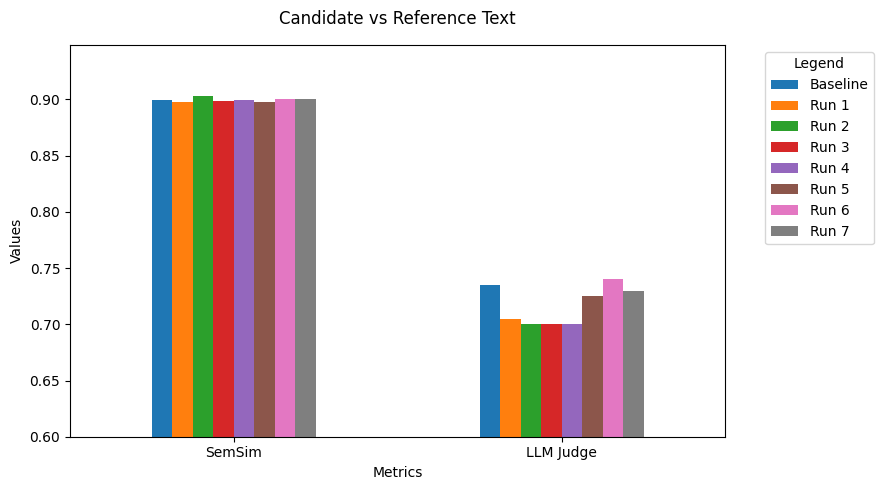

In [ ]:
# List to hold results Dataframes
results_dfs = []

# Iterate over run results
for run_data in key_runs_data:
    # Create DataFrame for each run and set 'name' column as index
    df = pd.DataFrame(run_data, index=[0])
    df.set_index('name_run', inplace=True)
    results_dfs.append(df)

# Concatenate DataFrames for all runs
results_df_combined = pd.concat(results_dfs)

# Transpose the combined DataFrames
results_df_combined_transposed = results_df_combined.transpose()

# Plot bar chart
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

results_df_combined_transposed.plot(kind='bar', ax=ax)
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Candidate vs Reference Text', pad=15)
ax.tick_params(axis='x', rotation=0)
ax.set_xticklabels(['SemSim', 'LLM Judge'])
ax.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(bottom=0.6)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
# Display dataframe showing evalution results of key runs
df_kr_results = results_df_combined.round(4)
df_kr_results.reset_index(inplace=True)
df_kr_results.rename(columns={'name_run': 'Run_Name', 'semsim': 'SemSim', 'llm': 'LLM Judge'}, inplace=True)
print("Evaluation Results for Key Runs")
print(" "*75)
display(df_kr_results)
print(" "*75)

Evaluation Results for Key Runs
                                                                           


,Run_Name,SemSim,LLM Judge
0,Baseline,0.8993,0.735
1,Run 1,0.8979,0.705
2,Run 2,0.9034,0.700
3,Run 3,0.8985,0.700
4,Run 4,0.8999,0.700
5,Run 5,0.8979,0.725
6,Run 6,0.9006,0.740
7,Run 7,0.9003,0.730


In [4]:
final_specs = {
    "Run Name": ["Final Model"],
    "Embedding Model": ["avsolatorio/GIST-Embedding-v0"],
    "Chunk Size": [512],
    "Chunk Overlap": [50],
    "Retriever": ["Maximal Marginal Relevance"],
    "Top K": [8],
    "LLM": ["OpenAI GPT4o Mini"],
    "Temperature": [0.3]
}

df_final_specs = pd.DataFrame(final_specs)
df_final_specs

,Run Name,Embedding Model,Chunk Size,Chunk Overlap,Retriever,Top K,LLM,Temperature
0,Final Model,avsolatorio/GIST-Embedding-v0,512,50,Maximal Marginal Relevance,8,OpenAI GPT4o Mini,0.3


## Final Run on Test Dataset

In [ ]:
test_candidate_answers = generate_candidate_answers(test_num_list, dataset=test_dataset)

In [ ]:
test_eval_result = run_evaluation("Test Dataset", test_num_list, dataset=test_dataset, answers=test_candidate_answers)
display(test_eval_result)

{'name_run': 'Test Dataset', 'semsim': 0.881324776785425, 'llm': 0.7}

# Commentary

- Run 6 performed the best. Key runs were repeated to ensure repeatability of conclusions.

- Based on Run 1 vs Baseline, we observed that GPT 4o Mini performed marginally better than Claude 3.5 Sonnet for this evaluation. GPT 4o Mini is also substantially cheaper at \$0.15 per million input tokens and \$0.60 per million output tokens. Claude 3.5 Sonnet costs \$3 per million input tokens and \$15 per million output tokens. We will provide users with the option to use Claude 3.5 Sonnet or GPT 4o Mini. For the MVP, the price difference is negligible.  We will revisit this again perhaps with an open source LLM like the newly released Llama 3.1 especially since our value proposition is for the model to be freely available to educators.
